In [20]:
import composition as cp
import torch
import matplotlib.pyplot as plt

In [21]:
from composition import normalize_map, generate_normalized_grid, get_standard_normal, distance_to_line

In [22]:
def generate_checkerboard(H=10, W=10):
    """Generate a symmetric checkerboard pattern as a torch tensor."""
    return torch.tensor(torch.arange(H) % 2).repeat(W, 1) ^ torch.tensor(torch.arange(H) % 2).repeat(W, 1).T

def generate_gradient(H=10, W=10):
    """Generate a linear gradient pattern as a torch tensor."""
    return torch.linspace(0, 1, W).repeat(H, 1)

def generate_radial_pattern(H=10, W=10):
    """Generate a radial gradient pattern as a torch tensor."""
    x, y = torch.meshgrid(torch.linspace(-1, 1, W), torch.linspace(-1, 1, H), indexing="xy")
    return torch.sqrt(x**2 + y**2)

def generate_spiral(H=10, W=10):
    """Generate a simple spiral pattern as a torch tensor."""
    x, y = torch.meshgrid(torch.linspace(-1, 1, W), torch.linspace(-1, 1, H), indexing="xy")
    return torch.sin(10 * torch.atan2(y, x))

def generate_noise(H=10, W=10):
    """Generate random noise pattern as a torch tensor."""
    return torch.rand(H, W)

def generate_even_distribution(size=10):
    """Generate a pattern with evenly spaced salient pixels."""
    pattern = torch.zeros(size, size)
    pattern[::2, ::2] = 1  # Every second pixel is highlighted
    return pattern

In [ ]:
from composition import visualise_attn, normalize_map

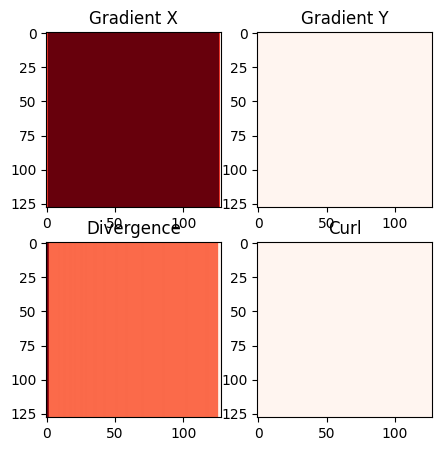

In [244]:
import torch.nn.functional as F


def compute_gradients(tensor):
    """
    Computes the gradient of a 2D PyTorch tensor using Sobel filters.
    Args:
        tensor (torch.Tensor): (H, W) normalized attention/saliency map.
    Returns:
        grad_x, grad_y: Gradients along x and y axes.
    """
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32, device=tensor.device).unsqueeze(0).unsqueeze(0)
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32, device=tensor.device).unsqueeze(0).unsqueeze(0)
    
    tensor = tensor.unsqueeze(0).unsqueeze(0)  # Add batch & channel dims -> (1, 1, H, W)
    grad_x = F.conv2d(F.pad(tensor, (1, 1, 1, 1), mode='replicate'), sobel_x).squeeze()  # (H, W)
    grad_y = F.conv2d(F.pad(tensor, (1, 1, 1, 1), mode='replicate'), sobel_y).squeeze()  # (H, W)
    
    return grad_x, grad_y

def compute_divergence(grad_x, grad_y):
    """
    Computes divergence: div(F) = dF_x/dx + dF_y/dy
    """
    kernel_x = torch.tensor([[-0.5, 0, 0.5]], dtype=torch.float32, device=grad_x.device).unsqueeze(0).unsqueeze(0)  # d/dx
    kernel_y = torch.tensor([[-0.5], [0], [0.5]], dtype=torch.float32, device=grad_y.device).unsqueeze(0).unsqueeze(0)  # d/dy
    
    dgrad_x_dx = F.conv2d(F.pad(grad_x.unsqueeze(0).unsqueeze(0), (1, 1, 0, 0), mode='replicate'), kernel_x).squeeze()
    dgrad_y_dy = F.conv2d(F.pad(grad_y.unsqueeze(0).unsqueeze(0), (0, 0, 1, 1), mode='replicate'), kernel_y).squeeze()
    
    return dgrad_x_dx + dgrad_y_dy

def compute_curl(grad_x, grad_y):
    """
    Computes curl: curl(F) = dF_y/dx - dF_x/dy
    """
    kernel_x = torch.tensor([[-0.5, 0, 0.5]], dtype=torch.float32, device=grad_x.device).unsqueeze(0).unsqueeze(0)  # d/dx
    kernel_y = torch.tensor([[-0.5], [0], [0.5]], dtype=torch.float32, device=grad_y.device).unsqueeze(0).unsqueeze(0)  # d/dy
    
    dgrad_y_dx = F.conv2d(F.pad(grad_y.unsqueeze(0).unsqueeze(0), (1, 1, 0, 0), mode='replicate'), kernel_x).squeeze()
    dgrad_x_dy = F.conv2d(F.pad(grad_x.unsqueeze(0).unsqueeze(0), (0, 0, 1, 1), mode='replicate'), kernel_y).squeeze()
    
    return dgrad_y_dx - dgrad_x_dy

# Example Usage
H, W = 128, 128  # Size of the saliency map
saliency_map = torch.rand((H, W), device="cpu")  # Simulated normalized saliency map
saliency_map = generate_gradient(H=H, W=W)
saliency_map = saliency_map.to(dtype=torch.float32)
# Compute metrics
grad_x, grad_y = compute_gradients(saliency_map)
divergence = compute_divergence(grad_x, grad_y)
curl = compute_curl(grad_x, grad_y)

# Convert to numpy for visualization
grad_x_np, grad_y_np = grad_x.cpu().numpy(), grad_y.cpu().numpy()
div_np, curl_np = divergence.cpu().numpy(), curl.cpu().numpy()

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(5, 5))
axes[0, 0].imshow(grad_x_np, cmap='Reds'); axes[0, 0].set_title("Gradient X")
axes[0, 1].imshow(grad_y_np, cmap='Reds'); axes[0, 1].set_title("Gradient Y")
axes[1, 0].imshow(div_np, cmap='Reds'); axes[1, 0].set_title("Divergence")
axes[1, 1].imshow(curl_np, cmap='Reds'); axes[1, 1].set_title("Curl")
plt.show()

In [246]:
grad_x = grad_x.unsqueeze(0)
grad_y = grad_y.unsqueeze(0)
gradients = torch.stack([grad_x, grad_y], dim=1)
print(gradients.shape)

torch.Size([1, 2, 128, 128])


In [257]:
def compute_divergence_and_curl(gradients):
    """
    Computes both divergence and curl from gradients.
    """

    # Define convolution kernels
    kernel_dx = torch.tensor([[-0.5, 0, 0.5]], dtype=torch.float32, device=gradients.device).unsqueeze(0)  # (1, 3)
    kernel_dy = torch.tensor([[-0.5], [0], [0.5]], dtype=torch.float32, device=gradients.device).unsqueeze(0)  # (3, 1)

    # Stack kernels correctly: (4, 1, kH, kW)
    stacked_dx = torch.stack([kernel_dx, kernel_dx])
    stacked_dy = torch.stack([kernel_dy, kernel_dy])

    # Apply grouped convolution to get all partials 
    partials_dx = F.conv2d(F.pad(gradients, (1, 1, 0, 0), mode='replicate'), stacked_dx, groups=2).unsqueeze(0)  # (2, H, W)
    partials_dy = F.conv2d(F.pad(gradients, (0, 0, 1, 1), mode='replicate'), stacked_dy, groups=2).unsqueeze(0)  # (2, H, W)
    
    # div(F) = dF_x/dx + dF_y/dy
    divergence = partials_dx[0] + partials_dy[1]  # (H, W)
    
    # curl(F) = dF_y/dx - dF_x/dy
    curl = partials_dx[1] - partials_dy[0] # (H, W)

    return divergence, curl

divergence_2, curl_2 = compute_divergence_and_curl(gradients)


torch.Size([1, 1, 3])


RuntimeError: stack expects each tensor to be equal size, but got [1, 1, 1, 3] at entry 0 and [1, 1, 3, 1] at entry 1

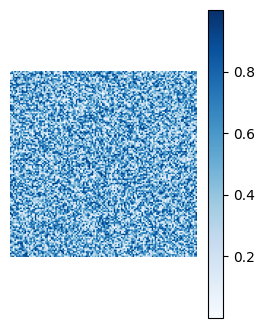

torch.Size([128, 128])
torch.Size([128, 128])


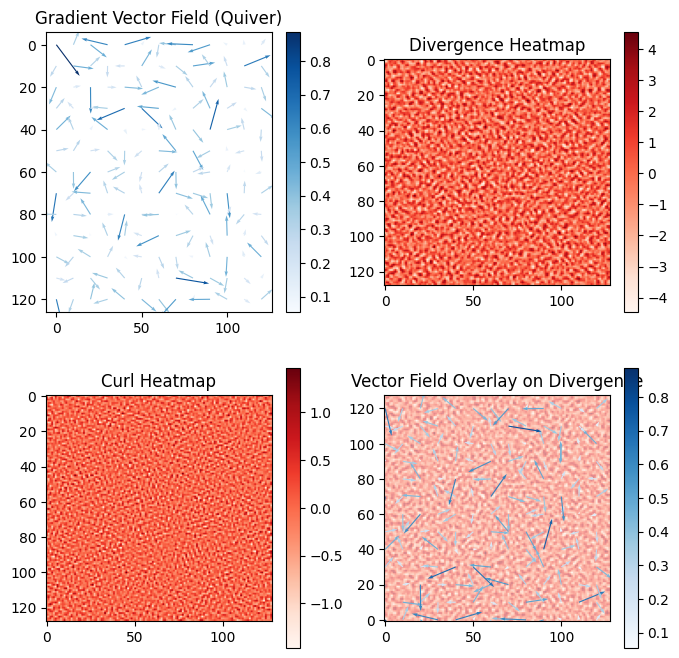

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def compute_gradients(attn_map, keep_aspect=True):
    """Computes gradients using Sobel filters."""
    H, W = attn_map.shape
    attn_map = attn_map.to(dtype=torch.float32)  # Ensure float32

    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32, device=attn_map.device).unsqueeze(0).unsqueeze(0)
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32, device=attn_map.device).unsqueeze(0).unsqueeze(0)

    attn_map = attn_map.unsqueeze(0).unsqueeze(0)  # Add batch & channel dims
    grad_x = F.conv2d(F.pad(attn_map, (1, 1, 1, 1), mode='replicate'), sobel_x)
    grad_y = F.conv2d(F.pad(attn_map, (1, 1, 1, 1), mode='replicate'), sobel_y)

    if keep_aspect:
        grad_x = grad_x * (2 / W)       # Scale by grid range [-1, 1] in x-direction
        grad_y = grad_y * (2*(H/W) / H) # Scale by grid range [-H/W, H/W] in y-direction

    gradients = torch.cat([grad_x, grad_y], dim=1) # Shape (1, 2, H, W)
    
    return gradients

def compute_divergence_and_curl(gradients):
    """
    Computes both divergence and curl from gradients using grouped convolutions.
    """

    # Define convolution kernels
    kernel_dx = torch.tensor([[-0.5, 0, 0.5]], dtype=torch.float32, device=gradients.device).unsqueeze(0)  # (1, 3)
    kernel_dy = torch.tensor([[-0.5], [0], [0.5]], dtype=torch.float32, device=gradients.device).unsqueeze(0)  # (3, 1)

    # Stack kernels correctly: (2, 1, kH, kW) for group conv
    stacked_dx = torch.stack([kernel_dx, kernel_dx], dim=0)  # Shape: (2, 1, 1, 3)
    stacked_dy = torch.stack([kernel_dy, kernel_dy], dim=0)  # Shape: (2, 1, 3, 1)

    # Apply grouped convolution to compute all four partial derivatives
    partials_dx = F.conv2d(F.pad(gradients, (1, 1, 0, 0), mode='replicate'), stacked_dx, groups=2).squeeze(0)  # Shape: (1, 2, H, W)
    partials_dy = F.conv2d(F.pad(gradients, (0, 0, 1, 1), mode='replicate'), stacked_dy, groups=2).squeeze(0)  # Shape: (1, 2, H, W)

    # Compute divergence: div(F) = dF_x/dx + dF_y/dy
    divergence = partials_dx[0] + partials_dy[1]  # Shape: (1, H, W)

    # Compute curl: curl(F) = dF_y/dx - dF_x/dy
    curl = partials_dx[1] - partials_dy[0]  # Shape: (1, H, W)

    return divergence, curl

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def visualize_vector_field(grad_x, grad_y, divergence, curl, step=5, scale=50, width=10):
    """
    Visualizes gradient vectors, divergence, and curl as vector fields.
    
    Args:
        grad_x, grad_y: Gradient components.
        divergence, curl: Derived scalar fields.
        step: Subsampling step for quiver plot (higher = fewer arrows).
        scale: Scaling factor for arrow size.
        width: Width of quiver arrows.
    """
    H, W = grad_x.shape
    X, Y = np.meshgrid(np.arange(W), np.arange(H))  # Grid coordinates

    # Convert tensors to numpy
    grad_x_np, grad_y_np = grad_x.cpu().numpy(), grad_y.cpu().numpy()
    div_np, curl_np = divergence.cpu().numpy(), curl.cpu().numpy()

    magnitude = np.sqrt(grad_x_np**2 + grad_y_np**2)
    magnitude = magnitude / (magnitude.max() + 1e-5)  # Normalize to [0,1]

    max_mag = magnitude.max()
    if max_mag > 1e-5:
        grad_x_np /= max_mag
        grad_y_np /= max_mag

    fig, axes = plt.subplots(2, 2, figsize=(8, 8))

    # Subsample for better visibility
    X_sub, Y_sub = X[::step, ::step], Y[::step, ::step]
    grad_x_sub, grad_y_sub = grad_x_np[::step, ::step], grad_y_np[::step, ::step]
    mag_sub = magnitude[::step, ::step]

    # Gradient vector field with magnitude-based color
    q = axes[0, 0].quiver(X_sub, Y_sub, grad_x_sub, -grad_y_sub, mag_sub, cmap="Blues", scale=scale, width=width)
    axes[0, 0].set_title("Gradient Vector Field (Quiver)")
    axes[0, 0].invert_yaxis()
    fig.colorbar(q, ax=axes[0, 0])

    # Divergence heatmap
    im1 = axes[0, 1].imshow(div_np, cmap='Reds')
    axes[0, 1].set_title("Divergence Heatmap")
    fig.colorbar(im1, ax=axes[0, 1])

    # Curl heatmap
    im2 = axes[1, 0].imshow(curl_np, cmap='Reds')
    axes[1, 0].set_title("Curl Heatmap")
    fig.colorbar(im2, ax=axes[1, 0])

    # Overlay quiver on divergence
    axes[1, 1].imshow(div_np, cmap='Reds', alpha=0.5)  # Transparency
    q2 = axes[1, 1].quiver(X_sub, Y_sub, grad_x_sub, -grad_y_sub, mag_sub, cmap="Blues", scale=scale, width=width)
    axes[1, 1].set_title("Vector Field Overlay on Divergence")
    axes[1, 1].invert_yaxis()
    fig.colorbar(q2, ax=axes[1, 1])

# Example Usage

# divergence = compute_divergence(grad_x, grad_y)
# curl = compute_curl(grad_x, grad_y)
# print(curl.shape)
# print(divergence.shape)

# # Visualize with improved quiver visibility
# visualize_vector_field(grad_x, grad_y, divergence, curl, step=10, scale=20, width=0.005)


In [260]:
tensor = torch.randn(16, 32)
H, W = tensor.shape
tensor = tensor.to(dtype=torch.float32)  # Ensure float32

sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32, device=tensor.device).unsqueeze(0).unsqueeze(0)
sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32, device=tensor.device).unsqueeze(0).unsqueeze(0)

tensor = tensor.unsqueeze(0).unsqueeze(0)  # Add batch & channel dims
grad_x = F.conv2d(F.pad(tensor, (1, 1, 1, 1), mode='replicate'), sobel_x)
grad_y = F.conv2d(F.pad(tensor, (1, 1, 1, 1), mode='replicate'), sobel_y)

grad_x = grad_x * (2 / W)  # Scale by grid range [-1, 1] in x-direction
grad_y = grad_y * (2*(H/W) / H)  # Scale by grid range [-H/W, H/W] in y-direction

gradients = torch.cat([grad_x, grad_y], dim=1)

grad_x = grad_x.squeeze()
grad_y = grad_y.squeeze()
divergence = compute_divergence(grad_x, grad_y)
curl = compute_curl(grad_x, grad_y)


In [ ]:
import torch
import torch.nn.functional as F



div_2, curl_2 = compute_divergence_and_curl(gradients)


torch.Size([1, 2, 16, 32])
torch.Size([2, 16, 32])


In [281]:
assert torch.allclose(curl, curl_2, atol=1e-6), "Divergence tensors do not match!"



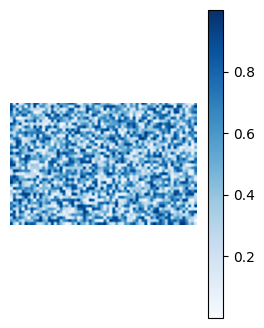

torch.Size([42, 64])


In [279]:
H, W = 42, 64  # Image dimensions
saliency_map = torch.rand((H, W), device="cpu").to(dtype=torch.float32)  # Simulated saliency map
visualise_attn(saliency_map)
# saliency_map = generate_gradient(H=H, W=W)
saliency_map = saliency_map.to(dtype=torch.float32)

# Compute gradients, divergence, and curl
grad_x, grad_y = compute_gradients(saliency_map)
print(grad_x.shape)

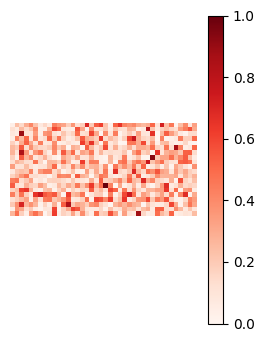

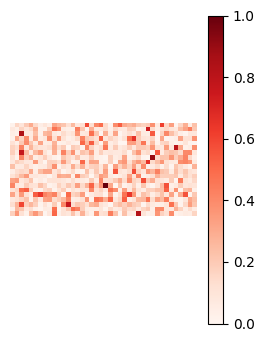

In [182]:
# attn_map = generate_gradient(H=40, W=40) 
attn_map = torch.abs(torch.randn(20, 40)) *1e-32 / 2
# attn_map = generate_gradient(H=40, W=64)
H, W = attn_map.shape
attn_map = attn_map.to(dtype=torch.float32)
attn_map = normalize_map(attn_map)
visualise_attn(attn_map, cmap="Reds")

attn_map = softmax_normalization(attn_map, temperature=1)
attn_map = normalize_map(attn_map)
visualise_attn(attn_map, cmap="Reds")

# focal_strength = torch.max(attn_norm) / (torch.mean(attn_norm) + 1e6)
# print(f"Focal strength: {focal_strength}")

# attn_map = attn_map * focal_strength
# visualise_attn(attn_map, cmap="Reds")
# focal_strength = torch.max(attn_map) / (torch.mean(attn_map) + 1e6)
# print(f"Focal strength: {focal_strength}")


# attn_map = softmax_normalization(attn_map, temperature=0.5)
# visualise_attn(attn_map, cmap="Reds")

# # attn_map = normalize_map(attn_map)
# # attn_map = softmax_normalization(attn_map, temperature=1/focal_strength)
# # # attn_map = torch.log1p(attn_map)
# # print(f"Max:{torch.max(attn_map)}" )
# # visualise_attn(attn_map, cmap="Reds")
# # print("Softmax")

# visualise_attn(attn_map, cmap="Reds")

# print("Focal weight softmax then normalized")
# visualise_attn(attn_map, cmap="Reds")
# positions = cp.generate_normalized_grid(H, W, keep_aspect=True)
# attn_mass = torch.sum(attn_map)

# # Compute center of mass

# print(f"Focus strength: {focal_strength.item()}")
# moments = torch.sum(attn_map.unsqueeze(-1) * positions, dim=(0,1))
# centroid = moments / attn_mass
# print(f"Centroid: {centroid}")
# center = (centroid * torch.Tensor([W // 2, H // 2])) + torch.Tensor([W // 2, H // 2])
# visualise_attn(attn_map, centroid=center)
# d_VB = torch.sum(torch.abs(centroid ))
# print(f"Centroid manhattan: {d_VB}")
# e_VB = cp.gaussian_weighting(d_VB, sigma=0.1)
# print(f"Centroid gaussian energy: {e_VB}")

# # Compute moment of inertia
# squared_distances = torch.sum(attn_map.unsqueeze(-1) * ((positions - centroid)** 2), dim=(0, 1))
# variance = squared_distances / attn_mass
# print(f"Variance: {variance}")
# moment_of_inertia = torch.sum(squared_distances / (H * W))
# print(f"Moment of inertia: {moment_of_inertia}")

# # Compute moment of inertia
# right_diag = get_standard_normal(type="right_diag", H=H, W=W)
# left_diag = get_standard_normal(type="left_diag", H=H, W=W)
# angular_right = torch.sum(attn_map * distance_to_line(positions, right_diag, signed=True))
# angular_left = torch.sum(attn_map * distance_to_line(positions, left_diag, signed=True))
# print(f"Momentum about right diag: {angular_right}")
# print(f"Momentum about left diag: {angular_left}")

# vertical = get_standard_normal(type="vertical", H=H, W=W)
# angular_y = torch.sum(attn_map * distance_to_line(positions, vertical, signed=True))
# print(f"Momentum about center: {angular_y}")


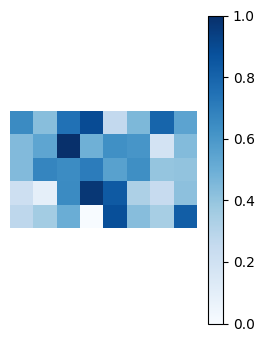

In [33]:

attn_map_softmax = normalize_map(attn_map)
visualise_attn(attn_map_softmax)

/var/folders/18/h9m9_ktj0j95_gs7__ncptgc0000gn/T/ipykernel_63755/3079313098.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.arange(H) % 2).repeat(W, 1) ^ torch.tensor(torch.arange(H) % 2).repeat(W, 1).T


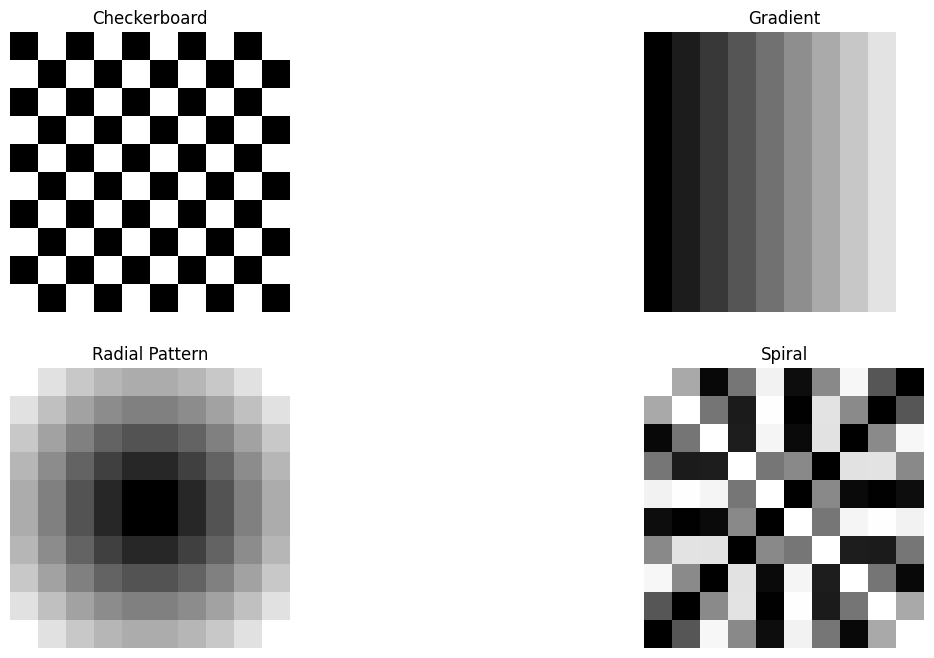

In [ ]:
# Generate all patterns
patterns = {
    "Checkerboard": generate_checkerboard(),
    "Gradient": generate_gradient(),
    "Radial Pattern": generate_radial_pattern(),
    "Spiral": generate_spiral(),
    "Noise": generate_noise(),
}

# Display the patterns
fig, axes = plt.subplots(2, len(patterns) // 2, figsize=(15, 8))
axes = axes.flatten()
for ax, (title, pattern) in zip(axes, patterns.items()):
    ax.imshow(pattern, cmap='gray', interpolation='nearest')
    ax.set_title(title)
    ax.axis('off')